# Model evaluation by ecotype
Evaluate the evaporative stress index parameterization at different IGBP ecotypes using FLUXNET 2015 data. β values are calculated for each ecotype, and data is grouped by ecotype depending on the success of the parameterization in describing the Priestly Taylor evaporative stress index. <br><br>This notebook uses functions defined in the utils module, and are not explicity described here.

In [1]:
"""FLUXNET_ecotype_analysis.ipynb 

Notebook for computing beta and ESI for FLUXNET 2015 dataset 

Author: Nicole Keeney 
Date Created: Dec 2020
Modification History: 
    - computing Beta by site, cleaning notebook, changed utils.ipynb to a python module (May 2021)

"""

import pandas as pd 
import numpy as np 
import os
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
import seaborn as sns

#import functions from other notebooks
import utils as utils

#increase resolution of plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75

# Load data file from local drive

In [2]:
pathname = 'data/FLUXNET2015_monthly.csv'
fluxMonthly = pd.read_csv(pathname)
display(fluxMonthly[:5])

,DATE,FLUXNET-ID,IGBP,LE (W/m^2),VPD (kPa),TA (deg C),NETRAD (W/m^2),G (W/m^2),PA (kPa),RH,Std Dev RH
0,2011-01-01,US-CRT,CRO,5.317504,0.101241,-5.489418,9.618696,-4.961629,99.831905,0.757487,0.102424
1,2011-02-01,US-CRT,CRO,11.828405,0.145528,-2.971717,20.088240,-0.771094,99.859839,0.737630,0.134346
2,2011-03-01,US-CRT,CRO,34.717653,0.197390,2.153819,92.061066,11.126964,100.084974,0.747895,0.144803
3,2011-04-01,US-CRT,CRO,45.258565,0.307019,7.368077,96.613316,11.045620,99.294018,0.737826,0.150827
4,2011-05-01,US-CRT,CRO,82.249253,0.444950,15.870246,143.585133,13.552872,99.448677,0.794998,0.157474


# Compute β by site

In [3]:
site_names = fluxMonthly["FLUXNET-ID"].unique() # Get unique site names in FLUXNET database 

#empty list for storing beta values
betas = []
for site in site_names: 
    
    # Get all data for that one site, stored as a dataframe
    fluxSite = fluxMonthly.loc[fluxMonthly["FLUXNET-ID"] == site].reset_index(drop = True) 
    
    # Compute ESI from Priestly Taylor equation
    fluxSite = utils.addESI_PT(fluxSite, upperLimit = 1)
    
    # Compute Beta
    betaSite = utils.minimize_b(x = fluxSite['RH'].values, 
                               y = fluxSite['ESI PT (W/m^2)'].values, 
                               VPD = fluxSite['VPD (kPa)'].values)
    betas.append(betaSite)

## Drop values of β > some upper bound (I chose 5)
I feel like beta values > 10 are just bad values. You could easily change this though. 

In [4]:
upper_bound = 5
beta_by_site_df = pd.DataFrame({"Site Name": site_names, "Beta": betas})
beta_by_site_df = beta_by_site_df.where(beta_by_site_df["Beta"] <= upper_bound, np.nan).dropna()
display(beta_by_site_df) 

,Site Name,Beta
0,US-CRT,1.78
1,IT-Tor,2.26
5,AU-Wac,0.54
6,CN-Du3,2.76
7,AU-Emr,1.80
...,...,...
140,ES-LJu,2.96
141,CA-Obs,2.94
142,US-Me5,4.78
144,ES-Amo,3.84


## Make histogram!
To change the bins, change the variable "upper bound" in the code box above, or change the variable "bins" in the code box below

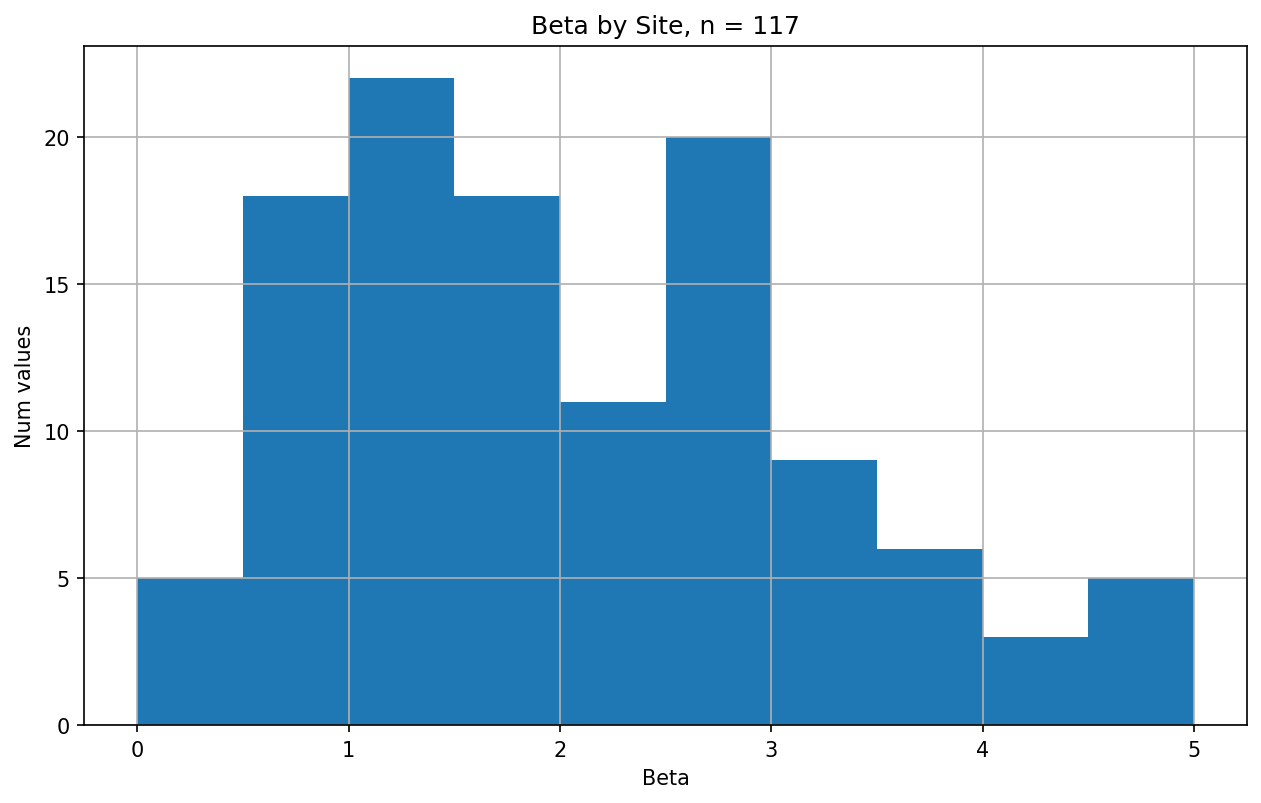

In [5]:
bins = np.arange(0, upper_bound + 0.5, 0.5) # Set bins
beta_by_site_df.hist(figsize = (10,6), bins = bins) # Create histogram
plt.title("Beta by Site, n = " + str(len(beta_by_site_df)))
plt.xlabel("Beta")
plt.ylabel("Num values")
plt.show() # Show plot

# Calculate β for each ecotype

## Create a table of IGBP ecotypes and descriptions

In [6]:
igbp_code = ['ALL','CRO','CSH','DBF','EBF','ENF','GRA','MF','OSH','SAV','WET','WSA']
igbp_description = ['All Ecotypes','Croplands','Closed Shrublands','Deciduous Broadleaf Forests',
                    'Evergreen Broadleaf Forests','Evergreen Needleleaf Forests','Grasslands',
                    'Mixed Forests','Open Shrublands','Savannas','Permanent Wetlands',
                    'Woody Savannas']
dfECO = pd.DataFrame({'IGBP' : igbp_code,'Description': igbp_description})

## Compute β 

In [7]:
#empty list for storing beta values
ecoList, betas, numValues = [],[],[]
for ecotype in dfECO['IGBP'].values:
    #restrict dataframe by ecotype
    if ecotype == 'ALL': 
        fluxEco = fluxMonthly.copy()
    else:
        fluxEco = fluxMonthly.loc[fluxMonthly['IGBP'] == ecotype].reset_index(drop = True)
    
    #compute ESI from Priestly Taylor equation
    fluxEco = utils.addESI_PT(fluxEco, upperLimit = 1)
    
    #compute Beta
    betaEco = utils.minimize_b(x = fluxEco['RH'].values, y = fluxEco['ESI PT (W/m^2)'].values, VPD = fluxEco['VPD (kPa)'].values)
    
    #add ESI parameterization from Beta calculation as column to the table 
    ESI_B = [utils.f_RH(RH = fluxEco['RH'].values[i], VPD = fluxEco['VPD (kPa)'].values[i], B = betaEco) for i in range(len(fluxEco))]
    fluxEco.insert(loc = 4, column = 'model ESI (W/m^2)', value = ESI_B)
    
    #append values to list
    ecoList.append(fluxEco)
    betas.append(betaEco)
    numValues.append(len(fluxEco))

## Add data to table
Add β values and total data points used in calculation as columns to table.

In [8]:
dfECO['β value'] = betas
dfECO['Num values used in β calculation'] = numValues
display(dfECO)

,IGBP,Description,β value,Num values used in β calculation
0,ALL,All Ecotypes,2.33,7492
1,CRO,Croplands,1.71,560
2,CSH,Closed Shrublands,4.97,109
3,DBF,Deciduous Broadleaf Forests,3.67,863
4,EBF,Evergreen Broadleaf Forests,2.32,392
5,ENF,Evergreen Needleleaf Forests,3.11,2194
6,GRA,Grasslands,1.29,1323
7,MF,Mixed Forests,4.80,593
8,OSH,Open Shrublands,2.74,322
9,SAV,Savannas,0.78,329


# Generate plots by ecotype, and calculate SSR 
SSR = sum of square residuals, a way to evaluate fit of model

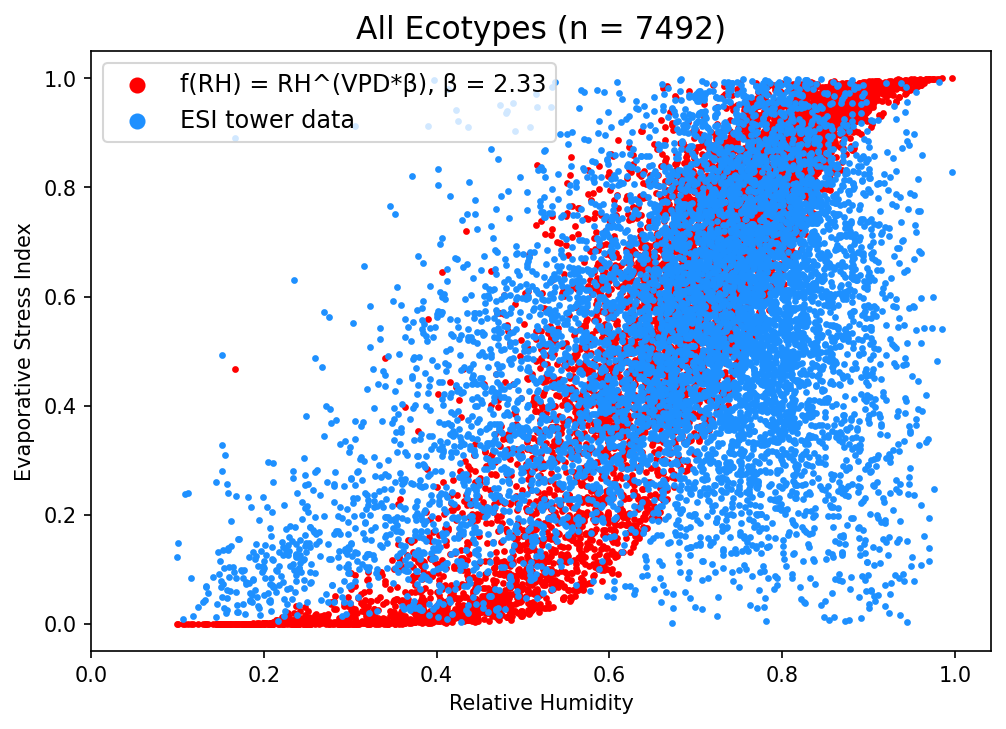

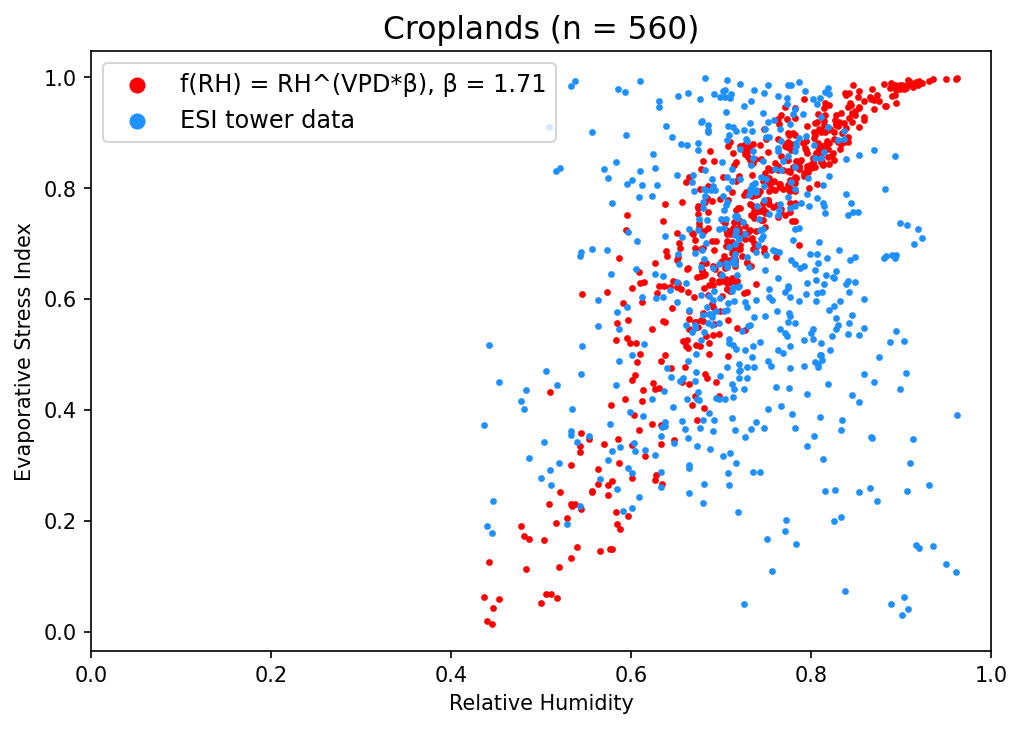

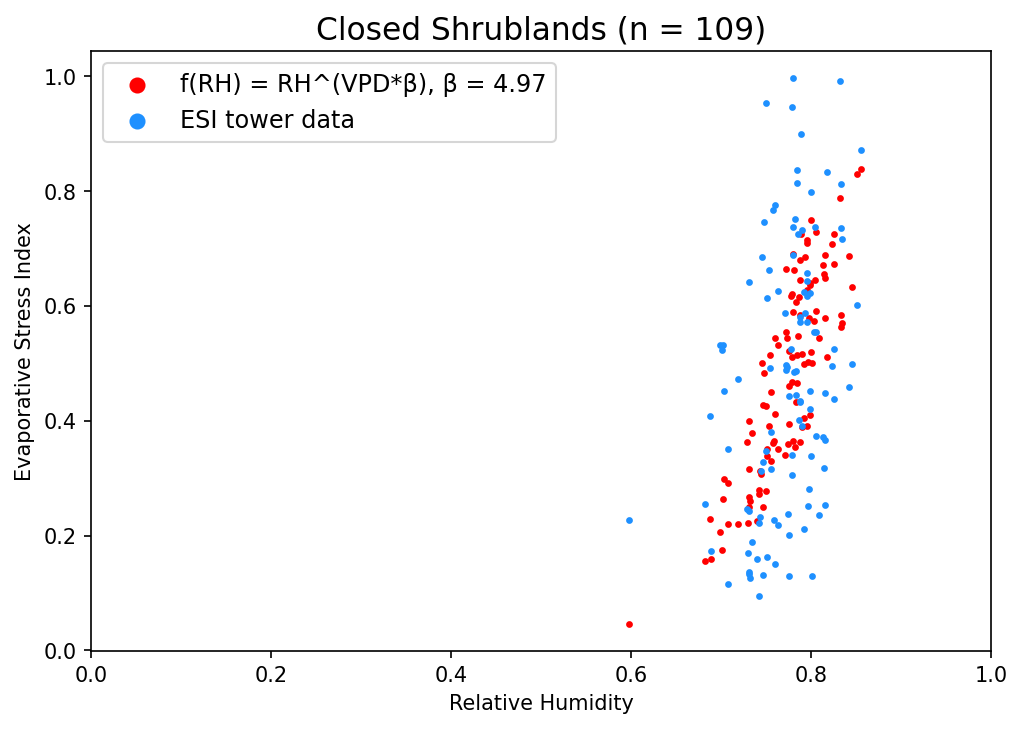

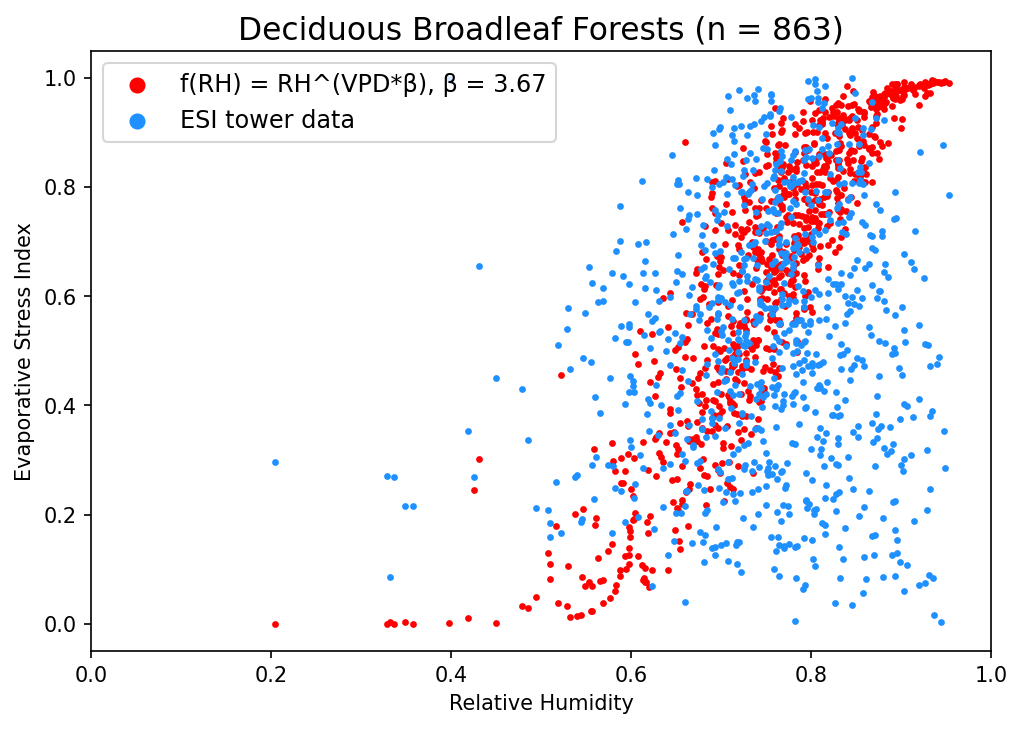

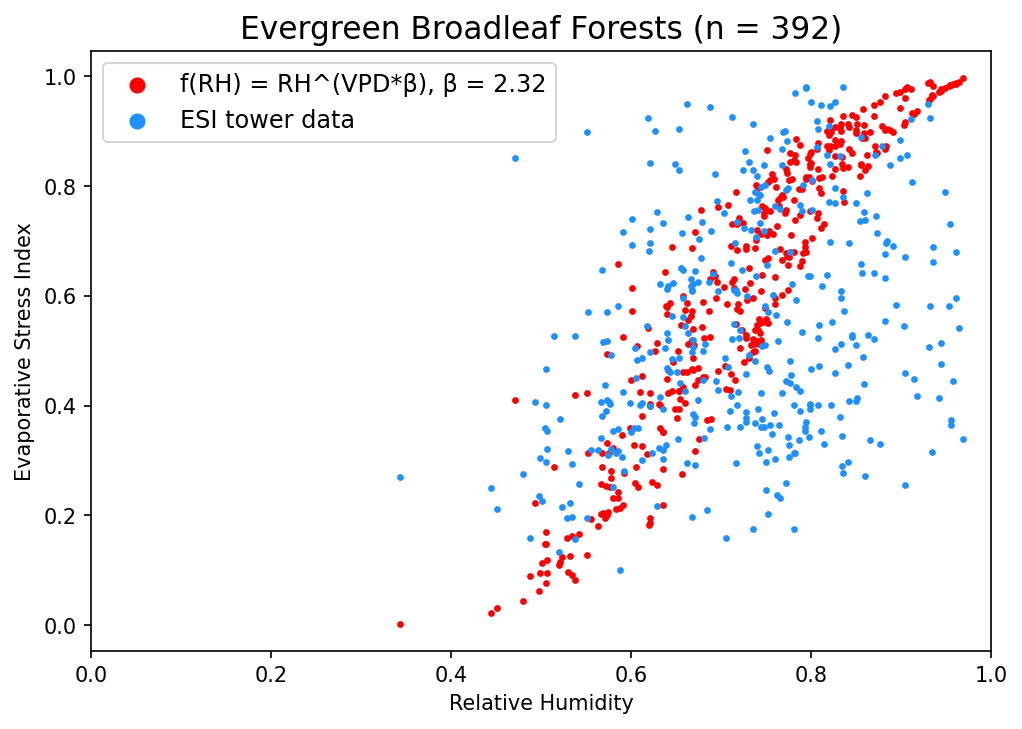

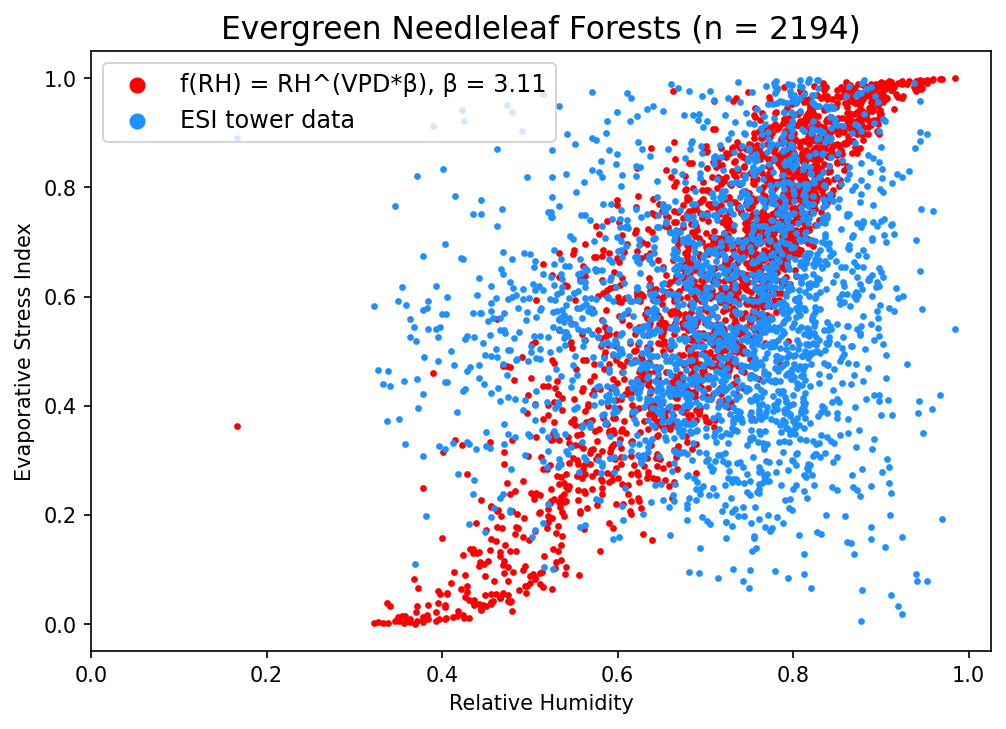

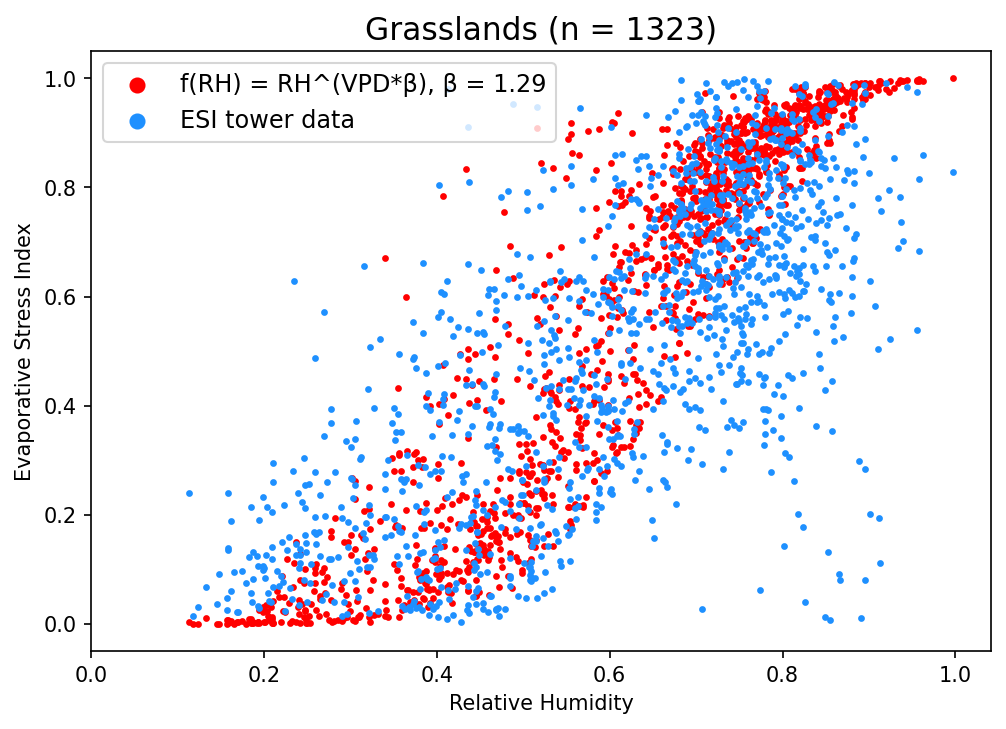

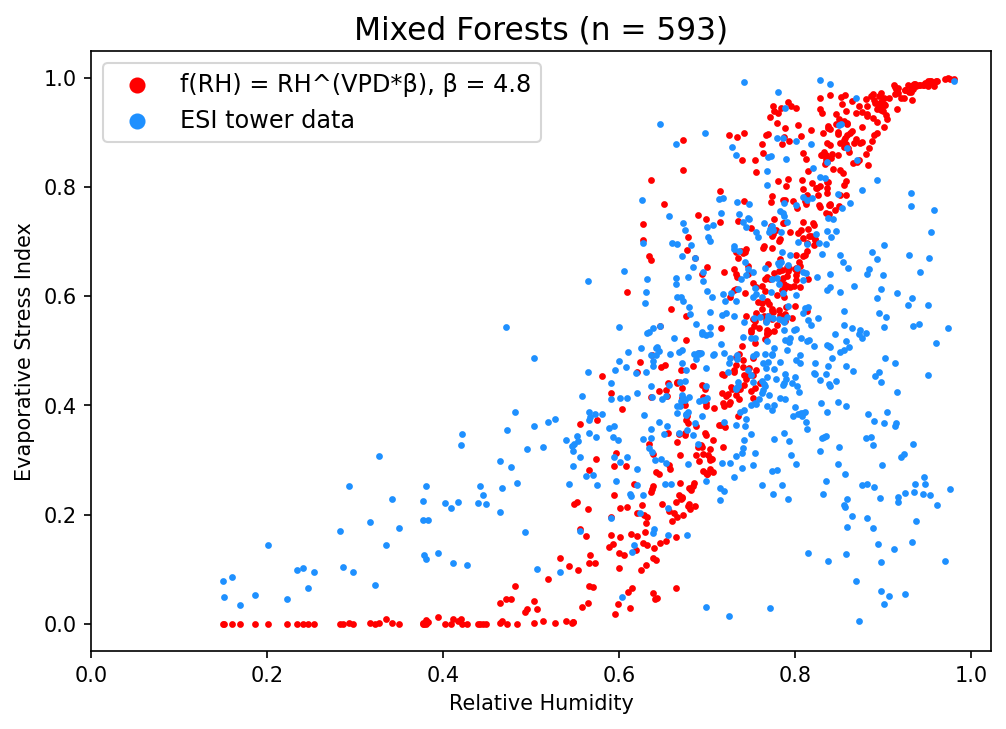

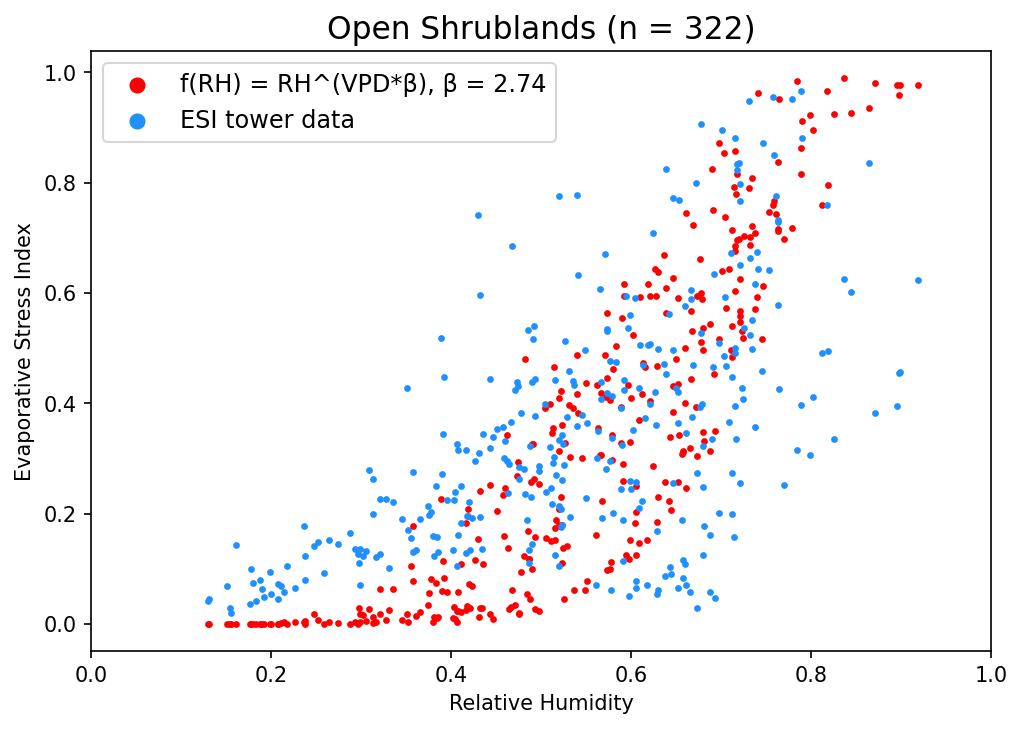

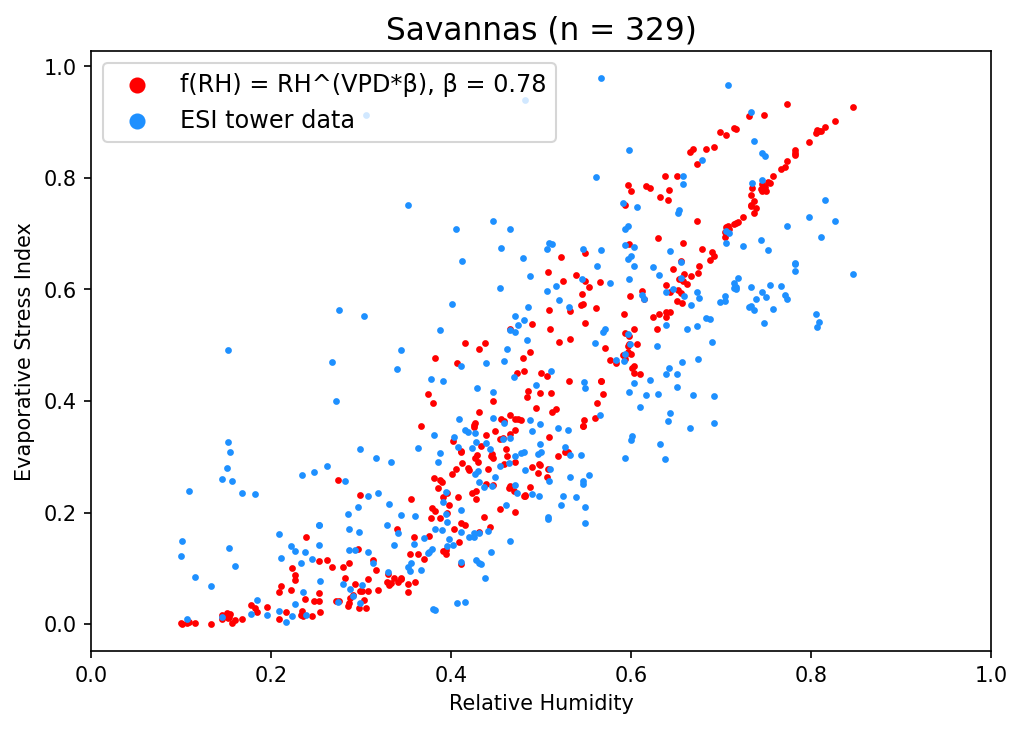

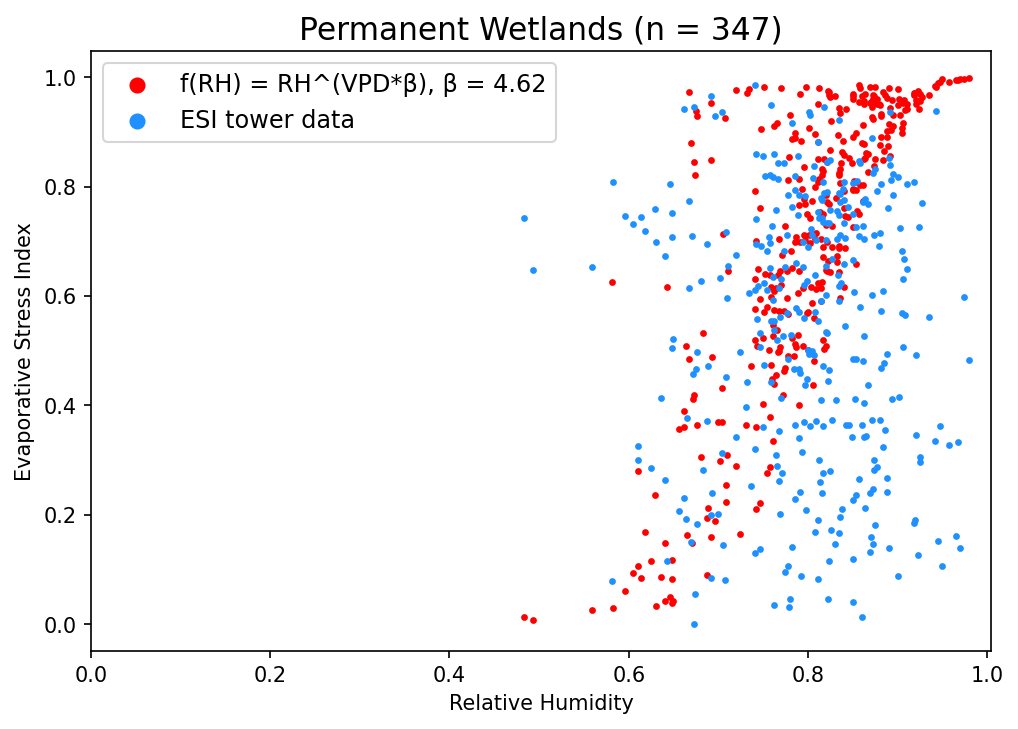

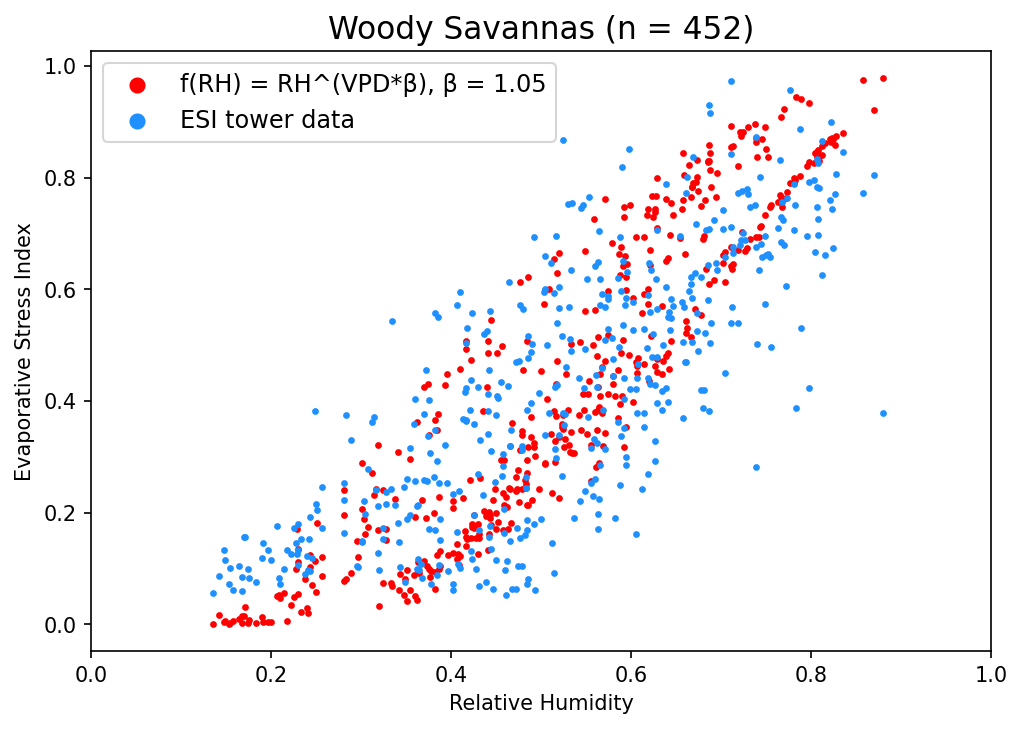

In [9]:
SSRList, RMSEList = [],[]
for i in range(len(ecoList)): 
    df = ecoList[i]
    
    #calculate residuals 
    residuals = np.array([df['model ESI (W/m^2)'][i]-df['ESI PT (W/m^2)'][i] for i in range(len(df['ESI PT (W/m^2)']))])
    SSR = round(np.mean(np.abs(residuals**2)),3)
    SSRList.append(SSR)
    RMSE = np.sqrt(mean_squared_error(df['ESI PT (W/m^2)'],df['model ESI (W/m^2)']))
    RMSEList.append(RMSE)

    #plot
    utils.plotESI(RH = df['RH'].values, ESI_PT = df['ESI PT (W/m^2)'].values, ESI_B = df['model ESI (W/m^2)'].values, Beta = dfECO['β value'].values[i], title = dfECO['Description'].values[i] + ' (n = ' + str(dfECO['Num values used in β calculation'].values[i]) + ')', 
                  markersize = 5)

#add SSR as column to table 
dfECO['SSR'] = SSRList
dfECO['RMSE'] = RMSEList

## Sort table by smallest sum of square residuals
The residual in this case represents model ESI - Priestley Taylor ESI (not a regression line) 

In [10]:
dfECO = dfECO.sort_values(by = 'RMSE', ascending = True)
display(dfECO)

,IGBP,Description,β value,Num values used in β calculation,SSR,RMSE
11,WSA,Woody Savannas,1.05,452,0.035,0.187027
2,CSH,Closed Shrublands,4.97,109,0.047,0.216417
9,SAV,Savannas,0.78,329,0.049,0.222128
8,OSH,Open Shrublands,2.74,322,0.053,0.231078
6,GRA,Grasslands,1.29,1323,0.060,0.245868
4,EBF,Evergreen Broadleaf Forests,2.32,392,0.075,0.273400
1,CRO,Croplands,1.71,560,0.088,0.295992
5,ENF,Evergreen Needleleaf Forests,3.11,2194,0.090,0.299621
0,ALL,All Ecotypes,2.33,7492,0.102,0.318595
7,MF,Mixed Forests,4.80,593,0.122,0.349158
